# Visualize the Number of Cells Measured per Well

**Gregory Way, 2019**

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
set.seed(123)

In [3]:
# Read in well counts
sc_col_types <- readr::cols(
    Metadata_Well = readr::col_character(),
    cell_count = readr::col_integer(),
    batch_id = readr::col_character(),
    sc_type = readr::col_character()
)

file <- file.path("results", "well_cell_counts.tsv")
num_sc_df <- readr::read_tsv(file, col_types = sc_col_types)

dim(num_sc_df)
head(num_sc_df, 2)

Warning message:
“Missing column names filled in: 'X1' [1]”

[1] 2228    5

X1,Metadata_Well,cell_count,batch_id,sc_type
<int>,<chr>,<int>,<chr>,<chr>
0,A01,152,BR00103267,all
1,A02,236,BR00103267,all


In [4]:
# Read in example file and merge with well
profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_plating_density = readr::col_integer(),
    Metadata_line_ID = readr::col_character(),
    Metadata_timepoint = readr::col_integer()
)

batches <- c("BR00103267", "BR00103268")

eg_list <- list()
for (batch in batches) {
    file <- file.path("data", paste0(batch, "_normalized_variable_selected.csv"))
    eg_list[[batch]] <- readr::read_csv(file, col_types = profile_cols)
}

eg_df <- do.call(rbind, eg_list)
eg_df <- eg_df %>% dplyr::select(starts_with("Metadata_"))

dim(eg_df)
head(eg_df, 2)

[1] 768   8

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
BR00103267,A01,BR00103267,cmQTL1-4_mt,A01,5000,A,6
BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6


In [5]:
# Merge with well
num_sc_df <- num_sc_df %>% 
    dplyr::left_join(eg_df,
                     by = c("Metadata_Well" = "Metadata_Well",
                            "batch_id" = "Metadata_Assay_Plate_Barcode")) %>%
    dplyr::select(-X1)

head(num_sc_df, 2)

Metadata_Well,cell_count,batch_id,sc_type,Metadata_Plate,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>
A01,152,BR00103267,all,BR00103267,cmQTL1-4_mt,A01,5000,A,6
A02,236,BR00103267,all,BR00103267,cmQTL1-4_mt,A02,5000,A,6


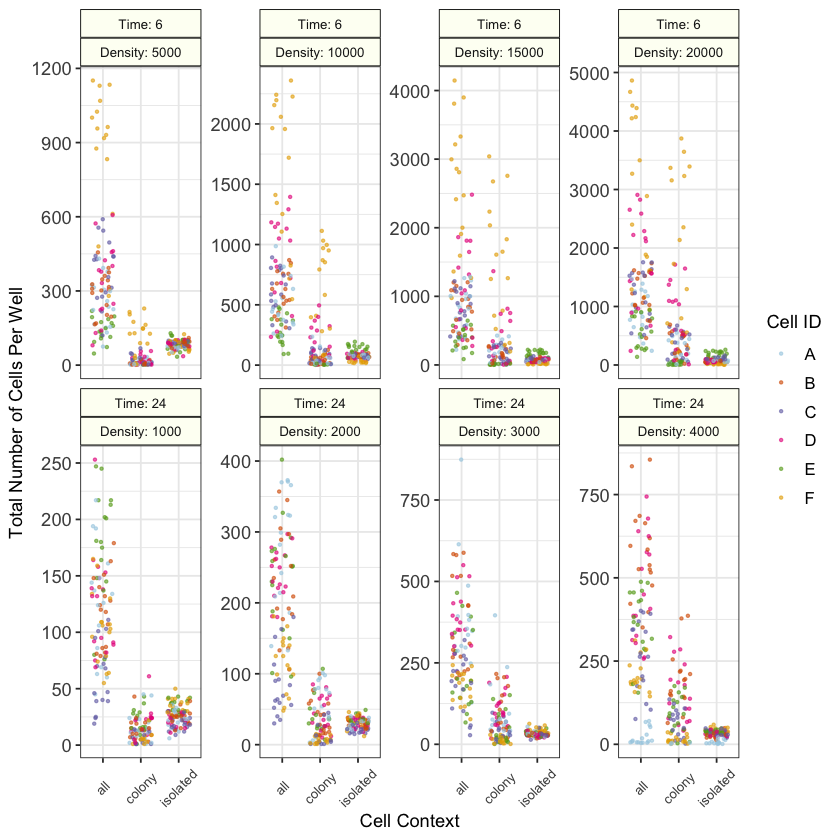

In [6]:
append_timepoint <- function(string) paste("Time:", string)
append_density <- function(string) paste("Density:", string)

ggplot(num_sc_df,
       aes(x = sc_type,
           y = cell_count,
           color = Metadata_line_ID)) +
        geom_jitter(size = 0.6,
                    alpha = 0.6,
                    height = 0,
                    width = 0.3) +
        facet_wrap(Metadata_timepoint ~ Metadata_plating_density,
                   ncol = 4, 
                   scales = "free_y",
                   labeller = labeller(Metadata_timepoint = as_labeller(append_timepoint),
                                       Metadata_plating_density = as_labeller(append_density))) +
        scale_color_manual(name = "Cell ID",
                           values = c("#a6cee3",
                                      "#d95f02",
                                      "#7570b3",
                                      "#e7298a",
                                      "#66a61e",
                                      "#e6ab02")) +
        ylab("Total Number of Cells Per Well") +
        xlab("Cell Context") +
        theme_bw() + 
        theme(axis.text.y = element_text(size = 11),
              axis.text.x = element_text(size = 8, angle = 45, vjust = 0.5),
              axis.title = element_text(size = 11),
              legend.text = element_text(size = 10),
              strip.text = element_text(size = 8),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))

file_base <- file.path("figures", paste0("sc_num_cells_pilot"))
for (extension in c('.png', '.pdf')) {
    ggsave(filename = paste0(file_base, extension),
           height = 5,
           width = 8)
}

In [7]:
file <- file.path("results", "well_cell_counts_with_metadata.tsv")
readr::write_tsv(num_sc_df, file)